In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set(style="darkgrid")
from scipy import stats
import matplotlib.patches as mpatches

In [2]:
data_types = {'Recall Notification Date': str}
df = pd.read_csv("database.csv", dtype=data_types)

In [3]:
df.dtypes

Record ID                     int64
NHTSA Campaign               object
Manufacturer Campaign        object
Vehicle Make                 object
Vehicle Model                object
Model Year                    int64
Vehicle Manufacturer         object
Recall Type                  object
Recall Component             object
Manufacture Start Date      float64
Manufacture End Date        float64
Estimated Units             float64
Recall Initiative            object
Recall Manufacturer          object
Recall Notification Date     object
dtype: object

In [4]:
ford_aliases = {
    'FORD MOTOR COMPANY',
    'FORD MOTOR COMPANY test adw as',
    'FORD MTR CO-OVERSEAS',
    'Ford Motor Company'
}

In [5]:
ford_df = df.loc[df['Vehicle Manufacturer'].isin(ford_aliases)]

In [6]:
ford_df_over_1_mil = ford_df.loc[df['Estimated Units'] > 2000000.0]

In [7]:
len(ford_df_over_1_mil)

508

In [8]:
ford_df_filtered = ford_df_over_1_mil.dropna(subset=['Recall Notification Date'])

In [9]:
ford_df_filtered_with_date = ford_df_filtered['Recall Notification Date'].apply(lambda x:pd.datetime.strptime(x, '%Y%m%d'))

In [10]:
type(ford_df_filtered['Estimated Units'])

pandas.core.series.Series

In [11]:
date_split_value = pd.datetime(1995, 1, 1) # ignore values before 1995

In [12]:
recalls_by_units_df = pd.DataFrame({
        'Recall Notification Date': ford_df_filtered_with_date,
        'Estimated Units': ford_df_filtered['Estimated Units']
})

In [13]:
recalls_by_units_df_after_1995 = recalls_by_units_df.loc[recalls_by_units_df['Recall Notification Date'] > date_split_value]

In [14]:
recalls_by_unit_after_1995_unique = recalls_by_units_df_after_1995.drop_duplicates()

In [15]:
ford_stock_data_types = {
    'Date': str,
    'Price': float
}
ford_stock = pd.read_csv('zstock_data_clean/ford_stock.txt', sep='\t', parse_dates=['Date'])

In [16]:
ford_stock_after_1995 = ford_stock.loc[ford_stock['Date'] > date_split_value]

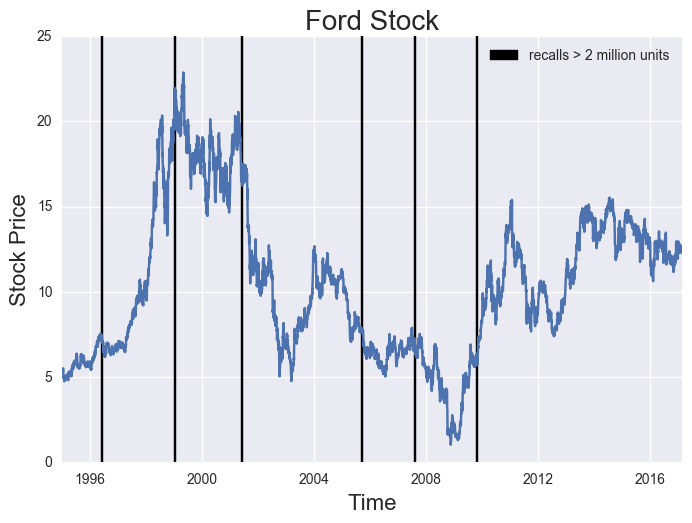

In [17]:
plt.plot(list(ford_stock_after_1995['Date']), list(ford_stock_after_1995['Price']))
#plt.scatter(list(recalls_by_unit_after_1995_unique['Recall Notification Date']), [25 for x in range(0, len(recalls_by_unit_after_1995_unique))])
#for i in range(0, len(recalls_by_unit_after_1995_unique))
#    plt.plot([, ])
my_dates_list = list(recalls_by_unit_after_1995_unique['Recall Notification Date'])
plt.vlines(x=my_dates_list, ymin=[0 for x in range(0, len(my_dates_list))], ymax=[25 for x in range(0, len(my_dates_list))])
plt.title('Ford Stock', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
black_patch = mpatches.Patch(color='black', label='recalls > 2 million units')
plt.legend(handles=[black_patch],
           loc='upper right')
plt.show()

In [18]:
type(ford_stock_after_1995['Date'][5707])

pandas.tslib.Timestamp

In [19]:
type(recalls_by_unit_after_1995_unique['Recall Notification Date'][4605])

pandas.tslib.Timestamp

In [20]:
ford_stock_after_1995_reset_indices = ford_stock_after_1995.reset_index()
ford_stock_after_1995_reset_indices.drop('index', axis=1, inplace=True)

In [21]:
z2001 = recalls_by_unit_after_1995_unique['Recall Notification Date'][4605]

In [22]:
z2001
print("z2001:", z2001)
print("z2001 - 1 day:", z2001 - pd.Timedelta(days=1))

z2001: 2001-06-04 00:00:00
z2001 - 1 day: 2001-06-03 00:00:00


In [23]:
idx_value = ford_stock_after_1995_reset_indices['Date'][ford_stock_after_1995_reset_indices['Date'] == z2001].index[0]

In [24]:
idx_value

1620

In [25]:
first_index = idx_value - 100
last_index = idx_value + 101
z2001_ford_stock_df = ford_stock_after_1995_reset_indices.iloc[first_index:last_index]

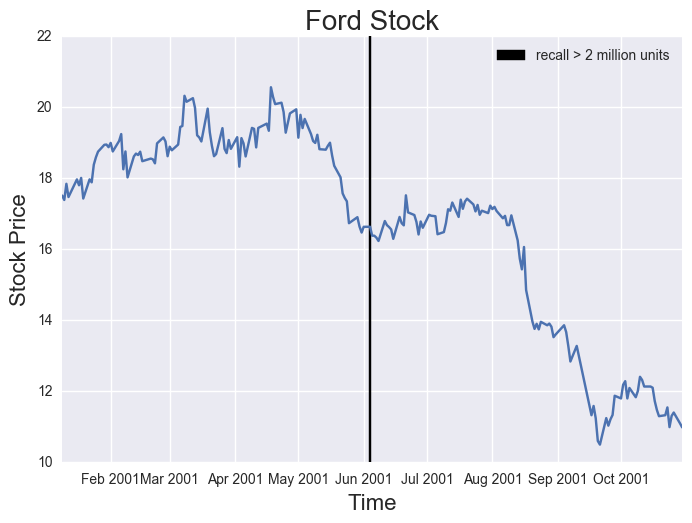

In [26]:
plt.plot(list(z2001_ford_stock_df['Date']), list(z2001_ford_stock_df['Price']))
plt.vlines(x=z2001, ymin=10, ymax=22)
plt.title('Ford Stock', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Stock Price', fontsize=16)
black_patch = mpatches.Patch(color='black', label='recall > 2 million units')
plt.legend(handles=[black_patch],
           loc='upper right')
plt.show()

In [27]:
len(z2001_ford_stock_df)

201

In [28]:
def find_returns(x):
    assert len(x) > 1
    returns = []
    for i in range(1, len(x)):
        ret = (x[i] - x[i-1]) / float(x[i])
        returns.append(ret)
    return returns

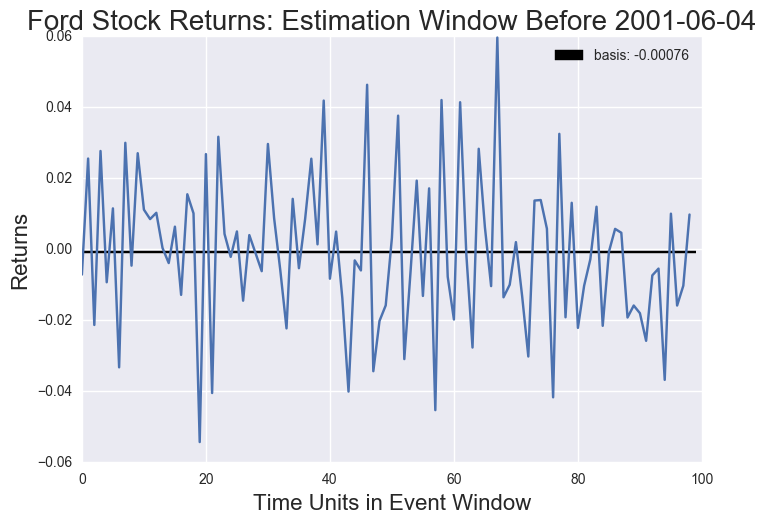

In [29]:
#find daily returns
prev_100_days = list(z2001_ford_stock_df['Price'][:100])
returns = find_returns(prev_100_days)
basis = sum(returns) / len(returns)
plt.plot(returns)
plt.hlines(y=basis, xmin=0, xmax=len(returns))
plt.title('Ford Stock Returns: Estimation Window Before {0:s}'.format(str(z2001).split()[0]), fontsize=20)
plt.xlabel('Time Units in Event Window', fontsize=16)
plt.ylabel('Returns', fontsize=16)
black_patch = mpatches.Patch(color='black', label='basis: {0:.5f}'.format(basis))
plt.legend(handles=[black_patch],
           loc='upper right')
plt.show()

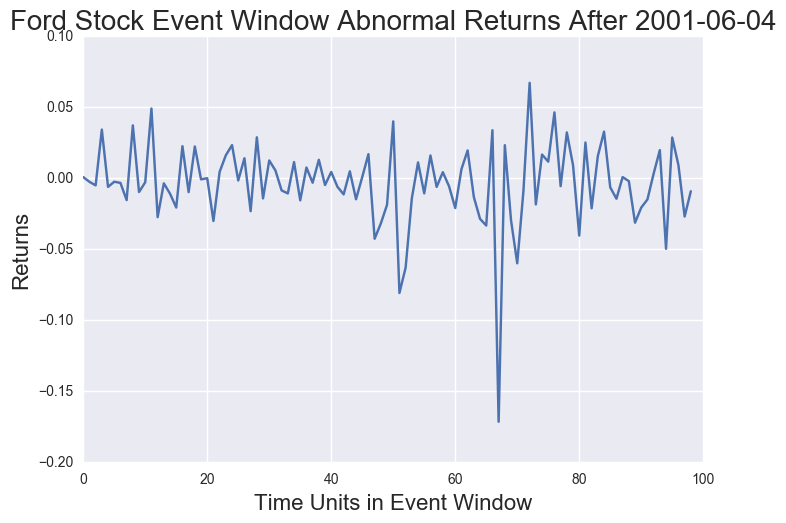

In [30]:
subsequent_100_days = list(z2001_ford_stock_df['Price'][101:])
subs_100_days_returns = find_returns(subsequent_100_days)
abnormal_returns = [x-basis for x in subs_100_days_returns]
plt.title('Ford Stock Event Window Abnormal Returns After {0:s}'.format(str(z2001).split()[0]), fontsize=20)
plt.xlabel('Time Units in Event Window', fontsize=16)
plt.ylabel('Returns', fontsize=16)
plt.plot(abnormal_returns)
plt.show()

In [31]:
CAR = sum(abnormal_returns)
CAR

-0.36652033545891677

In [32]:
# now we will conduct the event study
dates_arr = np.array(ford_stock_after_1995_reset_indices['Date'])
prices_arr = np.array(ford_stock_after_1995_reset_indices['Price'])
recalls_dates_arr = np.array(recalls_by_unit_after_1995_unique['Recall Notification Date'])

In [33]:
len(dates_arr)

5577

In [34]:
len(recalls_dates_arr)

6

In [35]:
recalls_dates_arr

array(['2001-06-04T00:00:00.000000000', '1999-01-18T00:00:00.000000000',
       '1996-06-07T00:00:00.000000000', '2005-09-12T00:00:00.000000000',
       '2009-10-27T00:00:00.000000000', '2007-08-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [36]:
d = recalls_dates_arr[1]
print(d)
d = d - pd.Timedelta(days=3)
d = np.datetime64(d)
np.argwhere(dates_arr == d)
print(d)
print(dates_arr[1020])

1999-01-18T00:00:00.000000000
1999-01-15T00:00:00.000000
1999-01-15T00:00:00.000000000


In [37]:
estimation_window = 50
event_window = 50

In [38]:
import event_study.event_study as evt

In [39]:
t_statistic, stdev, caar, car, abnormal_returns, bases = evt.event_study(stock_date_data=dates_arr,
                                                                           stock_price_data=prices_arr,
                                                                           event_dates=recalls_dates_arr,
                                                                           estimation_window=estimation_window,
                                                                           event_window=event_window)
print("t stat:", t_statistic)
print("stdev: ", stdev)

t stat: 0.3104671288
stdev:  0.240438911718


In [40]:
est_windows, evt_windows, indices = evt.calculate_estimation_and_event_windows(_stock_date_data=dates_arr,
                                                       _stock_price_data=prices_arr,
                                                       _event_dates=recalls_dates_arr,
                                                       _estimation_window=estimation_window,
                                                       _event_window=event_window)

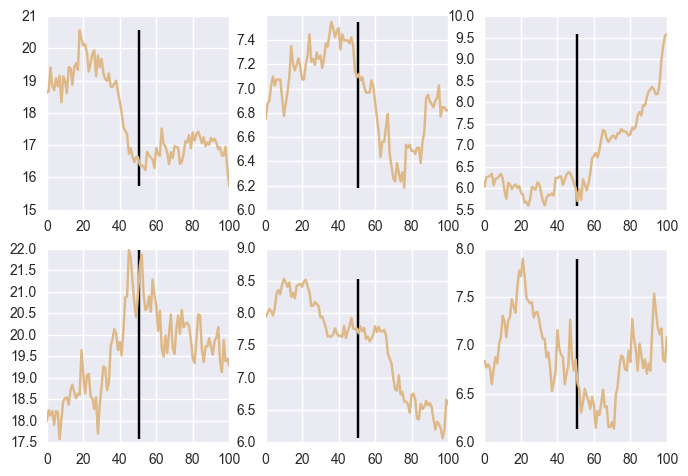

In [41]:
num_cols = 3
num_rows = 2
f, axarr = plt.subplots(num_rows, num_cols)
ith_period = 0
for col in range(0, 3):
    for row in range(0, 2):
        x1 = []
        x1.extend(est_windows[ith_period])
        x1.append(prices_arr[indices[ith_period]])
        x1.extend(evt_windows[ith_period])
        axarr[row, col].plot(x1, c='burlywood')
        axarr[row, col].vlines(x=len(x1)/2, ymin=min(x1), ymax=max(x1))
        ith_period += 1
plt.show()

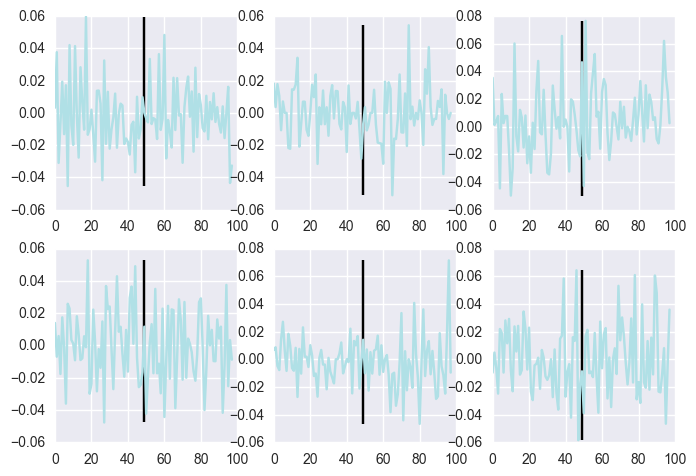

In [44]:
num_cols = 3
num_rows = 2
f, axarr = plt.subplots(num_rows, num_cols)
ith_period = 0
for col in range(0, 3):
    for row in range(0, 2):
        x1 = []
        estimation_window_returns = find_returns(est_windows[ith_period])
        event_window_returns = find_returns(evt_windows[ith_period])
        x1.extend(estimation_window_returns)
        x1.extend(event_window_returns)
        axarr[row, col].plot(x1, c='powderblue')
        axarr[row, col].vlines(x=len(x1)/2, ymin=min(x1), ymax=max(x1))
        ith_period += 1
plt.show()

In [ ]:
returns = find_returns(prev_100_days)
basis = sum(returns) / len(returns)

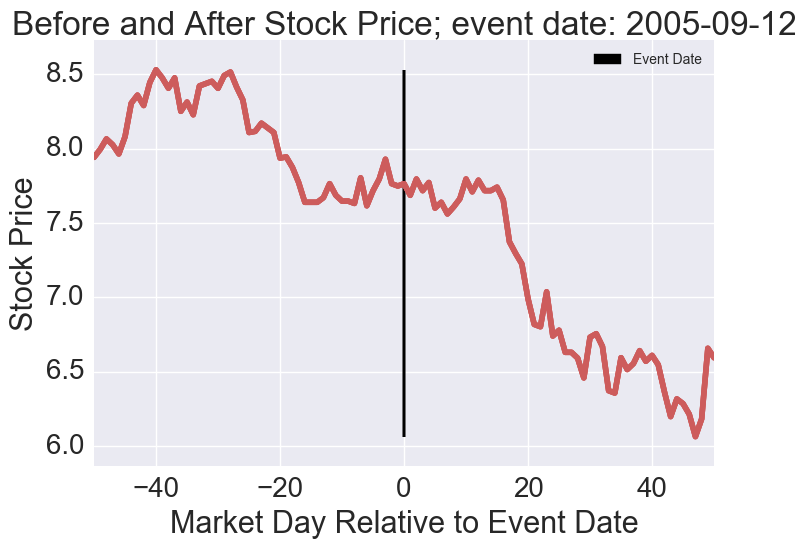

In [135]:
the_idx = 3
l = []
l.extend(est_windows[the_idx])
l.append(prices_arr[indices[the_idx]])
l.extend(evt_windows[the_idx])
plt.plot(range(-50,51,1), l, c='indianred', linewidth=4)
plt.vlines(x=0, ymin=min(l), ymax=max(l))
plt.title('Before and After Stock Price; event date: {:s}'.format(recalls_dates_arr[the_idx]).split("T00")[0], fontsize=24)
plt.xlabel('Market Day Relative to Event Date', fontsize=22)
plt.ylabel('Stock Price', fontsize=22)
plt.xlim((-50,50))
plt.ylim((min(l)-0.2, max(l)+0.2))
plt.tick_params(labelsize=20)
event_line_patch = mpatches.Patch(color='black', label='Event Date')
plt.legend(handles=[event_line_patch],
           loc='upper right')
plt.show()

In [107]:
plt.clf()